# Notebook to evaluate Benchmark Performance

In [1]:
import datetime

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import pyfolio as pf

from deep_rl_asset_allocation.utils import zipline_utils

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# "Agg" backend is for writing to file, not for rendering in a window
matplotlib.use('Agg')

# plotting in notebook
%matplotlib inline

In [4]:
# print options for pandas
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [5]:
%load_ext zipline

### Zipline: Min-Variance Optimization

In [ ]:
%%zipline --start 2016-1-4 --end 2020-5-7 --capital-base 1000000.0 --bundle djia-csvdir-bundle -o benchmark_min_var.pkl 
# %%zipline --start 2017-1-4 --end 2020-5-7 --capital-base 1000000.0 --bundle djia-csvdir-bundle -o benchmark_min_var.pkl 

from zipline.api import (symbol, symbols, record, order_target_percent, set_benchmark,
                         schedule_function, date_rules, time_rules)
from zipline.finance import commission
import numpy as np 
import pandas as pd
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def initialize(context):
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))
    set_benchmark(symbol('^DJI'))
    context.assets = symbols(
        'AAPL', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'DD', 'DIS', 'GS', 'HD',
        'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE',
        'PFE', 'PG', 'RTX', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT', 'XOM',
    )
    context.n_assets = len(context.assets)
    context.window = 252
    
    schedule_function(rebalance,
                      date_rules.month_end(),
                      time_rules.market_close())


def rebalance(context, data):
    cleaned_weights = []
        
    # extract prices
    prices = data.history(context.assets, fields='price', bar_count=context.window + 1, frequency='1d')

    # calculate expected returns and sample covariance matrix
    avg_returns = expected_returns.mean_historical_return(prices)
    cov_mat = risk_models.sample_cov(prices)

    ef = EfficientFrontier(avg_returns, cov_mat)
    # # get weights that optimizes for maximal Sharpe ratio
    # weights = ef.max_sharpe()
    # get weights that optimizes for minimum volatility
    weights = ef.min_volatility()
    cleaned_weights = ef.clean_weights()
    
    # submit orders
    for asset in context.assets:
        order_target_percent(asset, cleaned_weights[asset])
    
    record(weights=cleaned_weights)


Performance:
annualized_returns    0.098195
cumulative_returns    0.501761
annual_volatility     0.154420
sharpe_ratio          0.684145
sortino_ratio         0.958335
max_drawdown         -0.259338
dtype: float64


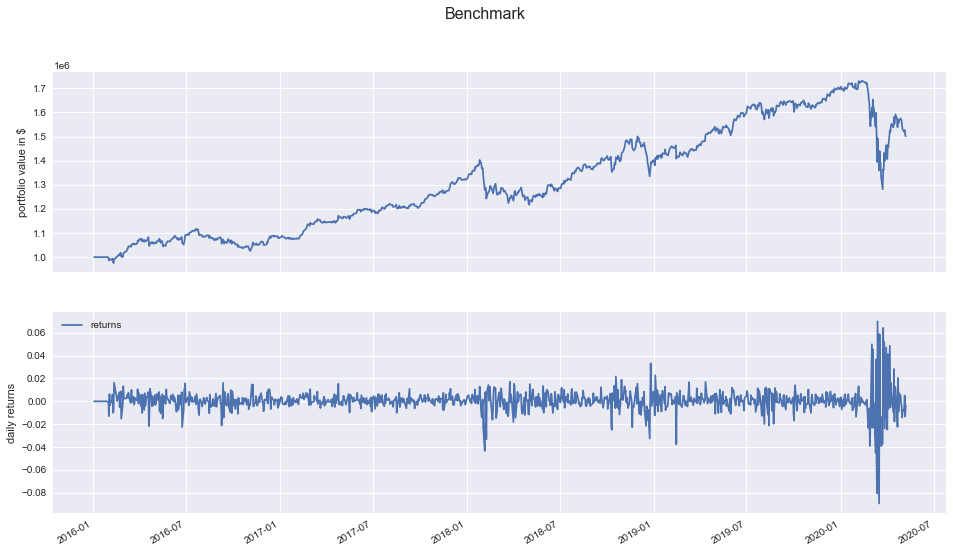

Final portfolio value (including cash): 1501760.87$


In [12]:
# read pkl file
benchmark_df = pd.read_pickle('benchmark_min_var.pkl')
# print(f"{benchmark_df.columns}")
# benchmark_df.benchmark_period_return
# benchmark_df.benchmark_volatility

# get transactions
transactions_list = []
for transactions in benchmark_df.transactions.values:
    if transactions != []:
        for transaction in transactions:
            transactions_list.append(transaction)
transactions = pd.DataFrame.from_records(transactions_list)
# print(transactions)

# get teardown
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(benchmark_df)
benchmark_perf = zipline_utils.get_performance_summary(returns)
print(f'\nPerformance:\n{benchmark_perf}')

# plot results
zipline_utils.visualize_results(df=benchmark_df, title="Benchmark")